## ANALISIS DE ENERGÍA DIARIA A PARTIR DE LOS DATOS DE SOLCAST Y FRONIUS 

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Lectura DB inversor Fronius 

In [2]:
#  Cargar los datos del archivo CSV
df_SFV = pd.read_csv('../Data/Cleaned/SFV_2023.csv', sep=',')


## Lectura DB Solcast 

In [3]:
# Cargar los datos del archivo CSV
df_solcast = pd.read_csv('../Data/Cleaned/solcast_2023.csv', sep=',')
print(df_solcast.shape)



(105408, 12)


## Método para filtrar datos de un solo día 

In [4]:
# filtrar un dia de datos 
Fecha = '2023-01-07'
row_day_solcast = df_solcast.loc[df_solcast['Date'] == Fecha]
row_day_fronius = df_SFV.loc[df_SFV['Date'] == Fecha]
print(row_day_solcast.shape)
print(row_day_fronius.shape)

(288, 12)
(288, 26)


In [10]:
# reiniciar el index
row_day_solcast = row_day_solcast.reset_index(drop=True)
row_day_fronius = row_day_fronius.reset_index(drop=True)

In [13]:
# Odenernar row_day_solcast de menor a mayor hora
row_day_solcast = row_day_solcast.sort_values(by='Time')
row_day_solcast = row_day_solcast.reset_index(drop=True)

In [14]:
# Crear un nuevo dataframe con los datos de solcast y fronius a partir del indice 
df = pd.DataFrame()
df['Time'] = row_day_solcast['Time']
df['GHI'] = row_day_solcast['GHI']
df['air_temp'] = row_day_solcast['air_temp']
df['cloud_opacity'] = row_day_solcast['cloud_opacity']
df['Producción_fotovoltaica_SFV'] = row_day_fronius['Producción_fotovoltaica_SFV']


## Análisis producción de energía 


In [24]:
# alpha y beta 
alpha = 0.1
beta = 0.5


#Parametros SFV
efficiency = 0.2094  # Eficiencia del panel solar
catidad_pv= 30
area =2.274*1.134

# normalizar 'cloud_opacity' de 0 a 1  en donde 1 es el valor más alto
df['cloud_opacity'] = df['cloud_opacity'] / df['cloud_opacity'].max()
# normalizar 'air_temp' de 0 a 1  en donde 1 es el valor más alto
df['air_temp'] = df['air_temp'] / df['air_temp'].max()


# Energía calculada a partir de Solcast 
df['P_cloud_opacity_temp'] = df['GHI'] * efficiency *  area * catidad_pv * (1 - beta*df['cloud_opacity']) * (1 - alpha*df['air_temp'])
# suma de la potencia generada solcast
energia = df['P_cloud_opacity_temp']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)



# Energía calculada a partir de Fronius
df['Potencia'] = df['Producción_fotovoltaica_SFV'] / (5/60)
energia_fronius = df['Producción_fotovoltaica_SFV'].sum()
print("Producción fotovoltaica SVF [kWh/día] =",energia_fronius/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# Horas de brillo solar
hbs = energia_fronius / (30*0.54)
print("Horas de brillo solar =", hbs/1000)

Energía calculada solacast [kWh] = 41.91330773840706
Producción fotovoltaica SVF [kWh/día] = 56.448260000000005
Error porcentual: 25.749159073446968 %
Horas de brillo solar = 3.48446049382716


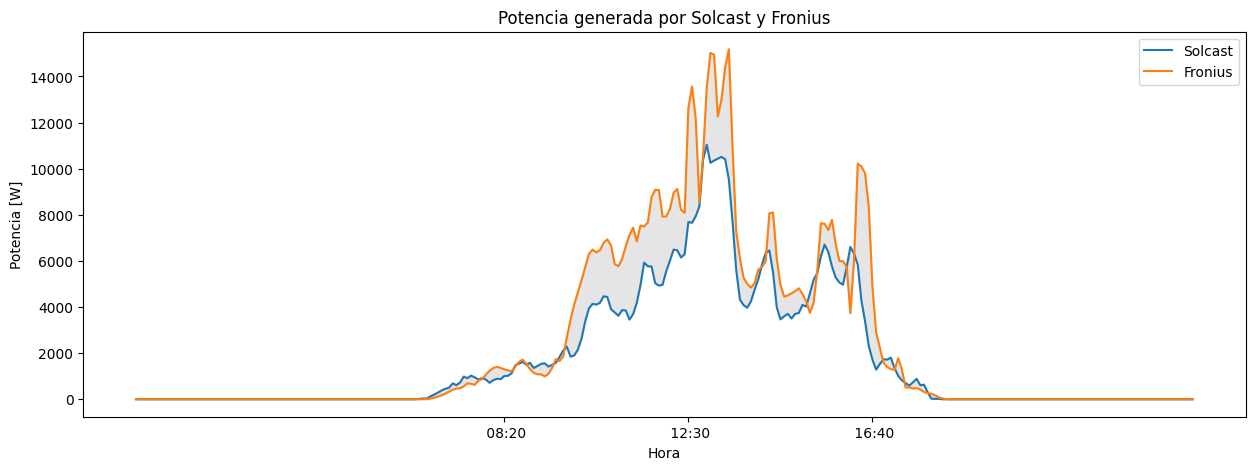

In [30]:
# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_cloud_opacity_temp'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_cloud_opacity_temp'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks([100, 150, 200])
plt.show()